## Gazprom Neft SmartOil Contest (31.08.2018 – 03.10.2018)

link: https://boosters.pro/gazprom_smartoil_contest

#### NOTEBOOK STRUCTURE:

0. Libraries and Functions
1. Data Preprocessing
2. Feature Engineering: Data Decomposition and Clustering
3. Modeling

## 0. Libraries and Functions

In [1]:
import pandas as pd
import numpy as np

import os   #path, listdir
PATH = '...'
os.chdir(PATH)

import datetime as dt

#Vizualisation
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#Green/Red colors: cm = sns.diverging_palette(10, 150, as_cmap=True)
cm = sns.light_palette("green", as_cmap=True)
sns.set_style("white")

#Use patsy‘s formula language to produce design matrices
import patsy

#Linear Regression
#import statsmodels.api as sm
#import statsmodels.formula.api as smf

#sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA, TruncatedSVD, FastICA, FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.cluster import KMeans

#Parameters' Optimization
#https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import xgboost as xgb

In [2]:
#checking for outliers
#https://stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation #0.6745 - 75% percentile of normal distribution

    return modified_z_score > thresh

In [3]:
#calculationg a difference in days between dates for each ID
def time_diff(train, column='date'):
    return train[column].diff()

#calculating a trend line for each ID
def trend(train):
    return pd.Series(np.arange(len(train)), index=train['date'])

#calculating a LOSS metric (MAE)
def mae(preds, actual):
    return (np.abs(preds - actual)).mean()

## 1. DATA PREPROCESSING

In [4]:
"""FRAC"""

#work with FRAC files: some info about test consists in train frac

#simple dictionary
symbols = (u"абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ",
           u"abvgdeejzijklmnoprstufhzcsstymeuaABVGDEEJZIJKLMNOPRSTUFHZCSSTYMEUA")

tr = {ord(a):ord(b) for a, b in zip(*symbols)}

#diwnload frac data
frac_train1 = pd.read_csv('frac_train_1.csv', engine='python')
frac_train2 = pd.read_csv('frac_train_2.csv', engine='python')
frac_test1 = pd.read_csv('frac_test_1.csv', engine='python')
frac_test2 = pd.read_csv('frac_test_2.csv', engine='python')

frac_train2.drop('Скважина_2', axis=1, inplace=True)

frac = pd.concat([frac_train1, frac_train2, frac_test1, frac_test2])
frac.reset_index(drop=True, inplace=True)

#checking for outliers
for i in frac.columns:
    if frac[i].dtypes == np.float64:
        frac.loc[frac[frac[i].isnull()==False][is_outlier(frac[frac[i].isnull()==False][i])][i].index, i] = np.nan

frac['Проппант'] = frac['Проппант'].apply(lambda x: str(x).lower()).apply(lambda x: x.translate(tr))

#label encoding: Проппант
prop_dict = {}
lbl = LabelEncoder()
lbl.fit_transform(frac['Проппант'].unique())
prop_dict['Проппант'] = dict(zip(lbl.classes_, range(len(lbl.classes_))))

frac['Проппант'] = frac['Проппант'].map(prop_dict['Проппант'])

#frac = pd.concat([frac, pd.get_dummies(frac['Проппант'], prefix='prop')], axis=1).drop('Проппант', axis=1)
frac = pd.concat([frac, pd.get_dummies(frac['Проппант'], prefix='prop')], axis=1)
frac = frac.drop_duplicates(subset='Скважина')

"""COORDS"""

#download cords files
coords_train1 = pd.read_csv('coords_train_1.1.csv', engine='python')
coords_test1 = pd.read_csv('coords_test_1.1.csv', engine='python')

coords_train2 = pd.read_csv('coords_train_2.1.csv', engine='python')
coords_test2 = pd.read_csv('coords_test_2.1.csv', engine='python')

coords = pd.concat([coords_train1, coords_train2, coords_test1, coords_test2])

#label encoding: ПЛАСТ
plast_dict = {}
lbl = LabelEncoder()
lbl.fit_transform(coords['ПЛАСТ'].unique())
plast_dict['ПЛАСТ'] = dict(zip(lbl.classes_, range(len(lbl.classes_))))

coords['ПЛАСТ'] = coords['ПЛАСТ'].map(plast_dict['ПЛАСТ']) 

#get dummies
coords = pd.concat([coords, pd.get_dummies(coords['ПЛАСТ'], prefix='pl')], axis=1)
coords.rename(columns={'well_hash':'Скважина'}, inplace=True)

#plast count
coords = pd.merge(coords, coords.groupby('Скважина')['ПЛАСТ'].count().reset_index(), 
                  on='Скважина', how='left').rename(columns={'ПЛАСТ_y':'plast_cnt'})

coords = pd.concat([coords[['УСТЬЕ_X', 'УСТЬЕ_Y', 'ПЛАСТ_X', 'ПЛАСТ_Y', 
                            'Альтитуда','Скважина', 'plast_cnt']].groupby('Скважина').median().reset_index(),
                    coords.groupby('Скважина').max()[['pl_' + str(i) for i in np.arange(16)]].reset_index(drop=True)], axis=1)

"""TRAIN & TEST: ALL TOGETHER"""
#download train and test
train1 = pd.read_csv('train_1.8.csv', engine='python')
test1 = pd.read_csv('test_1.9.csv', engine='python')
train2 = pd.read_csv('train_2.7.csv', engine='python')
test2 = pd.read_csv('test_2.9.csv', engine='python')

#concatinate and take only unique values
data = pd.concat([train1, train2, test1, test2])

#change format for some features
str_cols = ['Добыча растворенного газа, м3', 'Дебит попутного газа, м3/сут', 'Конденсат, т',
            'Приемистость, м3/сут', 'Обводненность (вес), %', 'Нефть, т', 'Нефть, м3', 'Жидкость, м3', 'Дебит конденсата',
            'Qж, т/сут', 'Вода, т', 'Жидкость, т']

for i in str_cols:
    data[i] = data[i].apply(lambda x: str(x).replace(',', '.')).astype(float)
    if i in train1.columns:
        train1[i] = train1[i].apply(lambda x: str(x).replace(',', '.')).astype(float)
    if i in train2.columns:
        train2[i] = train2[i].apply(lambda x: str(x).replace(',', '.')).astype(float)
    if i in test1.columns:
        test1[i] = test1[i].apply(lambda x: str(x).replace(',', '.')).astype(float)
    if i in test2.columns:
        test2[i] = test2[i].apply(lambda x: str(x).replace(',', '.')).astype(float)        

#obj/float features
object_cols = []
float_cols = []

for i in data.columns:
    if (data[i].dtype == 'float64') and ('Дата' not in i):
        float_cols.append(i)
    if data[i].dtype == 'object':
        object_cols.append(i)  
             
#group data by ID and take its median
skvajina_floats = data.groupby('Скважина')[float_cols].median().reset_index()

In [5]:
"""TRAIN AND TEST: SEPARATION"""

# select values in target variables with nan
id_train1_na = train1[train1['Нефть, т'].isnull()]['Скважина'].unique()
id_train2_na = train2[train2['Нефть, т'].isnull()]['Скважина'].unique()

trainset1_full = train1[train1['Скважина'].isin(id_train1_na) == False].reset_index(drop=True).copy()
trainset2_full = train2[train2['Скважина'].isin(id_train2_na) == False].reset_index(drop=True).copy()

#ID with month count < 6
#id_train2_short = list(trainset2_full['Скважина'].value_counts()[trainset2_full['Скважина'].value_counts() < 6].index)
#trainset2_full = trainset2_full[trainset2_full['Скважина'].isin(id_train2_short)==False].reset_index(drop=True)

#GRP = Hydraulic fracturing, fracking
trainset1_full['grp'] = 0
trainset2_full['grp'] = 0

for i in trainset2_full['Скважина'].unique():
    ind = trainset2_full[trainset2_full['Скважина']==i].index
    if len(trainset2_full[trainset2_full['Скважина']==i]) >= 6:
        trainset2_full.loc[ind[-6:], 'grp'] = 1
        
#create train and test sets (w or w/o 'Время работы, ч')
trainset = pd.concat([trainset1_full, trainset2_full])[['Скважина', 'Дата', 'Время работы, ч', 'grp', 'Нефть, т']]
#trainset = pd.concat([trainset1_full, trainset2_full])[['Скважина', 'Дата', 'grp', 'Нефть, т']]
trainset.reset_index(drop=True, inplace=True)

#testset1
test1['grp'] = 0
testset = test1[['Скважина', 'Дата', 'Время работы, ч', 'grp']].copy()
#testset = test1[['Скважина', 'Дата','grp']].copy()

trainset['date'] = trainset['Дата'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
testset['date'] = testset['Дата'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

#alternative date seems to be more appropriate to use
#trainset['date'] = trainset['date'] - trainset['date'].apply(lambda x: dt.timedelta(x.day-1))
#testset['date'] = (testset['date'] - dt.timedelta(days=1))

#test data by 1-id-month to data by 6-id-months

from dateutil.relativedelta import relativedelta

def apply_two_columns(row):
    return row['date'] + relativedelta(months=+row['linTrend'])

#testset
df = pd.DataFrame(testset['date'].repeat(6)).reset_index().groupby('index').apply(trend).reset_index()
df.rename(columns={0:'linTrend'}, inplace=True)
df['date'] = df.apply(apply_two_columns, axis=1)
df['year'] = df['date'].dt.year.values
df['quarter'] = df['date'].dt.quarter.values
df['month'] = df['date'].dt.month.values
df['days_in_month'] = df['date'].dt.daysinmonth.values

#checking different features
#df = pd.concat([df, pd.get_dummies(df.year, prefix='y')], axis=1)
#df = pd.concat([df, pd.get_dummies(df.quarter, prefix='q')], axis=1)
#df = pd.concat([df, pd.get_dummies(df.month, prefix='m')], axis=1)

#df = pd.concat([df, pd.get_dummies(df.linTrend, prefix='lin')], axis=1)

df['Время работы, ч'] = testset['Время работы, ч'].values.repeat(6)
df['Скважина'] = testset['Скважина'].values.repeat(6)

df.loc[df[df['linTrend']>0].index, 'Время работы, ч'] = (df[df['linTrend']>0]['days_in_month'] * 24).values

testset = df.drop(['index', 'days_in_month'], axis=1).copy()
testset['grp'] = 0

#trainset
trainset['year'] = trainset['date'].dt.year.values
trainset['quarter'] = trainset['date'].dt.quarter.values
trainset['month'] = trainset['date'].dt.month.values
trainset['days_in_month'] = trainset['date'].dt.daysinmonth.values

#trainset = pd.concat([trainset, pd.get_dummies(trainset.year, prefix='y')], axis=1)
#trainset = pd.concat([trainset, pd.get_dummies(trainset.quarter, prefix='q')], axis=1)
#trainset = pd.concat([trainset, pd.get_dummies(trainset.month, prefix='m')], axis=1)

#trainset = pd.concat([trainset, pd.get_dummies(trainset.linTrend, prefix='lin')], axis=1)
trainset.drop('Дата', axis=1, inplace=True)
trainset.rename(columns={'Нефть, т':'target'}, inplace=True)

#testset2
test2['grp'] = 1
testset2 = test2[['Скважина', 'Дата', 'Время работы, ч', 'grp']].copy()
#testset2 = test2[['Скважина', 'Дата', 'grp']].copy()
testset2['date'] = testset2['Дата'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

df = pd.DataFrame(testset2['date'].repeat(6)).reset_index().groupby('index').apply(trend).reset_index()
df.rename(columns={0:'linTrend'}, inplace=True)
df['date'] = df.apply(apply_two_columns, axis=1)
df['year'] = df['date'].dt.year.values
df['quarter'] = df['date'].dt.quarter.values
df['month'] = df['date'].dt.month.values
df['days_in_month'] = df['date'].dt.daysinmonth.values

#df = pd.concat([df, pd.get_dummies(df.year, prefix='y')], axis=1)
#df = pd.concat([df, pd.get_dummies(df.quarter, prefix='q')], axis=1)
#df = pd.concat([df, pd.get_dummies(df.month, prefix='m')], axis=1)

#df = pd.concat([df, pd.get_dummies(df.linTrend, prefix='lin')], axis=1)

df['Время работы, ч'] = testset2['Время работы, ч'].values.repeat(6)
df['Скважина'] = testset2['Скважина'].values.repeat(6)

df.loc[df[df['linTrend']>0].index, 'Время работы, ч'] = (df[df['linTrend']>0]['days_in_month'] * 24).values

testset2 = df.drop(['index', 'days_in_month'], axis=1).copy()
testset2['grp'] = 1

In [6]:
#testset1
#add linear trend for each ID-row
linTrend = pd.DataFrame(trainset.groupby('Скважина').apply(trend)).reset_index()
linTrend.columns = ['Скважина', 'date', 'linTrend']
trainset = pd.merge(trainset, linTrend, on=['Скважина', 'date'], how='left')

#add timedelta for each ID-row 
timedelta = pd.DataFrame(trainset.groupby('Скважина').apply(time_diff))
timedelta.columns = ['timeDiff']
timedelta = timedelta.reset_index()
timedelta.fillna(0, inplace=True) #fillna(31*24*60*60, inplace=True) #set NaN to 31 days
timedelta['timeDiff'] = (timedelta['timeDiff'] / np.timedelta64(1, 'D')).astype(int)
#timedelta.drop('level_1', axis=1, inplace=True)
trainset['timeDiff'] = 0
trainset.loc[timedelta['level_1'].values, 'timeDiff'] = timedelta['timeDiff'].values

#testset2
timedelta = pd.DataFrame(testset.groupby('Скважина').apply(time_diff))
timedelta.columns = ['timeDiff']
timedelta = timedelta.reset_index()
timedelta.fillna(0, inplace=True) #set NaN to 0/31 days
timedelta['timeDiff'] = (timedelta['timeDiff'] / np.timedelta64(1, 'D')).astype(int)
#timedelta.drop('level_1', axis=1, inplace=True)
testset['timeDiff'] = 0
testset.loc[timedelta['level_1'].values, 'timeDiff'] = timedelta['timeDiff'].values

timedelta = pd.DataFrame(testset2.groupby('Скважина').apply(time_diff))
timedelta.columns = ['timeDiff']
timedelta = timedelta.reset_index()
timedelta.fillna(0, inplace=True) #set NaN to 0/31 days
timedelta['timeDiff'] = (timedelta['timeDiff'] / np.timedelta64(1, 'D')).astype(int)
#timedelta.drop('level_1', axis=1, inplace=True)
testset2['timeDiff'] = 0
testset2.loc[timedelta['level_1'].values, 'timeDiff'] = timedelta['timeDiff'].values

In [7]:
#add ID data
#trainset = pd.merge(trainset, skvajina_floats, on='Скважина', how='left')
trainset = pd.merge(trainset, frac, on='Скважина', how='left')
trainset = pd.merge(trainset, coords, on='Скважина', how='left')

#testset = pd.merge(testset, skvajina_floats, on='Скважина', how='left')
testset = pd.merge(testset, frac, on='Скважина', how='left')
testset = pd.merge(testset, coords, on='Скважина', how='left')

#testset2 = pd.merge(testset2, skvajina_floats, on='Скважина', how='left')
testset2 = pd.merge(testset2, frac, on='Скважина', how='left')
testset2 = pd.merge(testset2, coords, on='Скважина', how='left')

#add additional trend for GRP rows
trainset['grp_trend'] = 0
trainset.loc[trainset[trainset['grp']==1].index, 'grp_trend'] = (np.arange(6).repeat(int(len(
    trainset[trainset['grp']==1])/6)).reshape(6, int(len(
    trainset[trainset['grp']==1])/6)).T.reshape(1, len(trainset[trainset['grp']==1])) + 1).T

testset['grp_trend'] = 0
testset2['grp_trend'] = (np.arange(6).repeat(
    int(len(testset2)/6)).reshape(6, int(len(testset2)/6)).T.reshape(1, len(testset2)) + 1).T

#drop IDs where sum = 0
id_with_sum_zero = list(trainset.groupby('Скважина')['target'].sum().sort_values()[:17].index)
trainset = trainset[trainset['Скважина'].isin(id_with_sum_zero)==False].reset_index(drop=True)

In [ ]:
%time
#extract info from las files
import lasio

las_name = listdir(PATH)
statistics = ['mean', 'median', 'sum', 'std', 'count', 'min', 'max']

las_table = pd.DataFrame()
for well in las_name:
    las = lasio.read(PATH + '\\' + str(well))
    
    key_list = las.keys()
    
    index_list=[]
    for i in statistics:
        for j in key_list:
            index_list.append(i+j)
    
    las_slice = pd.DataFrame(index=index_list)
        
    x = pd.DataFrame(las.data).mean(axis=0).values
    x = np.concatenate([x, pd.DataFrame(las.data).median(axis=0).values])
    x = np.concatenate([x, pd.DataFrame(las.data).sum(axis=0).values])
    x = np.concatenate([x, pd.DataFrame(las.data).std(axis=0).values])
    x = np.concatenate([x, pd.DataFrame(las.data).count(axis=0).values])
    x = np.concatenate([x, pd.DataFrame(las.data).min(axis=0).values])
    x = np.concatenate([x, pd.DataFrame(las.data).max(axis=0).values])
    
    las_slice[well[:-4]] = x
    las_table = pd.concat([las_table, las_slice], axis=1)

las_table.to_csv(PATH)

In [8]:
#read LAS file and add this file to the data
las_table = pd.read_csv('las_files.csv')
las_table = las_table.rename(columns={'Unnamed: 0': 'Скважина'})
take_cols = list(las_table.count().sort_values(ascending=False)[:252].index)

#las files
trainset = pd.merge(trainset, las_table[take_cols], on='Скважина', how='left')
testset = pd.merge(testset, las_table[take_cols], on='Скважина', how='left')
testset2 = pd.merge(testset2, las_table[take_cols], on='Скважина', how='left')

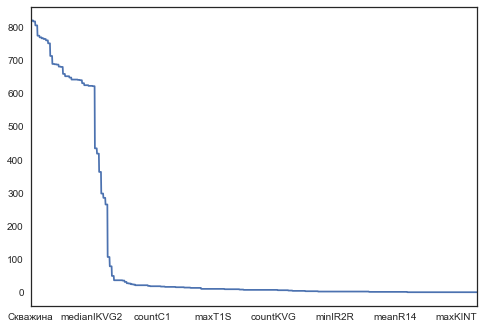

In [9]:
#visualize "amount" of usefull inforametion: not nan count for each featur in las file
las_table.count().sort_values(ascending=False).plot();

In [10]:
""" DICTIONARY / RENAMING """

short_cols_dic = {}
for i in trainset.columns:
    short_cols_dic[i] = i.lower().replace('%','').replace('/','').replace(',','').replace('.','').replace(' ', '_').replace(
        '/', '').replace('(', '').replace(')', '').replace('-', '')[:int(len(i))]

symbols = (u"абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ",
           u"abvgdeejzijklmnoprstufhzcsstymeuaABVGDEEJZIJKLMNOPRSTUFHZCSSTYMEUA")

tr = {ord(a):ord(b) for a, b in zip(*symbols)}

rus_to_eng_dic = {}
for i in trainset.columns:
    rus_to_eng_dic[i] = short_cols_dic[i].translate(tr)

trainset.rename(columns=rus_to_eng_dic, inplace=True) 
testset.rename(columns=rus_to_eng_dic, inplace=True) 
testset2.rename(columns=rus_to_eng_dic, inplace=True)

In [11]:
#for testset2 create shifted lintrend starting point
starting_point = trainset[trainset['skvajina'].isin(
    list(trainset.groupby('skvajina')['grp'].sum().sort_values(
        ascending=False)[:126].index))].groupby('skvajina')['target'].count().median()-6

testset2['lintrend'] = testset2['lintrend'] + int(starting_point)

## 2. Feature Engineering: Data Decomposition and Clustering

**Data Decomposition**: PCA, SVD, ICA, Random Projection

**Clustering**: K-Mean

In [13]:
#select cols which we will use in XGBoost
cols_xgb_del = ['date', 'skvajina'] + ['vrema_raboty_c', 'month', 'timediff', 'quarter', 'year']
cols_only_in_test = set(testset.columns) - set(trainset.columns)
cols_xgb = list(set(list(testset.drop(cols_xgb_del, axis=1).columns)) - cols_only_in_test)

In [14]:
#standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaler.fit(trainset[cols_xgb].fillna(0))

trainset_scaled = scaler.transform(trainset[cols_xgb].fillna(0))
testset_scaled = scaler.transform(testset[cols_xgb].fillna(0))
testset2_scaled = scaler.transform(testset2[cols_xgb].fillna(0))

In [15]:
#dimensionality reduction: use set of methods (decomposition and random projection)
from sklearn.decomposition import PCA, TruncatedSVD, FastICA, FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

N_COMP = 10

print("\nStart decomposition process...")
print("PCA")
pca = PCA(n_components=N_COMP, random_state=17)
pca_results_train = pca.fit_transform(trainset_scaled)
pca_results_test = pca.transform(testset_scaled)
pca_results_test2 = pca.transform(testset2_scaled)

print("tSVD")
tsvd = TruncatedSVD(n_components=N_COMP, random_state=17)
tsvd_results_train = tsvd.fit_transform(trainset_scaled)
tsvd_results_test = tsvd.transform(testset_scaled)
tsvd_results_test2 = tsvd.transform(testset2_scaled)

print("ICA")
ica = FastICA(n_components=N_COMP, random_state=17)
ica_results_train = ica.fit_transform(trainset_scaled)
ica_results_test = ica.transform(testset_scaled)
ica_results_test2 = ica.transform(testset2_scaled)

print("FA")
fa = FactorAnalysis(n_components=N_COMP, random_state=17)
fa_results_train = fa.fit_transform(trainset_scaled)
fa_results_test = fa.transform(testset_scaled)
fa_results_test2 = fa.transform(testset2_scaled)

print("GRP")
grp = GaussianRandomProjection(n_components=N_COMP, eps=0.1, random_state=17)
grp_results_train = grp.fit_transform(trainset_scaled)
grp_results_test = grp.transform(testset_scaled)
grp_results_test2 = grp.transform(testset2_scaled)

print("SRP")
srp = SparseRandomProjection(n_components=N_COMP, dense_output=True, random_state=17)
srp_results_train = srp.fit_transform(trainset_scaled)
srp_results_test = srp.transform(testset_scaled)
srp_results_test2 = srp.transform(testset2_scaled)

print("Append decomposition components to datasets...")

deco_names = []

for i in range(1, N_COMP + 1):
    deco_names.append('pca_' + str(i)), deco_names.append('tsvd_' + str(i)), deco_names.append('ica_' + str(i))
    deco_names.append('fa_' + str(i)), deco_names.append('grp_' + str(i)), deco_names.append('srp_' + str(i))
    
    trainset['pca_' + str(i)] = pca_results_train[:, i - 1]
    testset['pca_' + str(i)] = pca_results_test[:, i - 1]
    testset2['pca_' + str(i)] = pca_results_test2[:, i - 1]
    
    trainset['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    testset['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]
    testset2['tsvd_' + str(i)] = tsvd_results_test2[:, i - 1]

    trainset['ica_' + str(i)] = ica_results_train[:, i - 1]
    testset['ica_' + str(i)] = ica_results_test[:, i - 1]
    testset2['ica_' + str(i)] = ica_results_test2[:, i - 1]
    
    trainset['fa_' + str(i)] = fa_results_train[:, i - 1]
    testset['fa_' + str(i)] = fa_results_test[:, i - 1]
    testset2['fa_' + str(i)] = fa_results_test2[:, i - 1]

    trainset['grp_' + str(i)] = grp_results_train[:, i - 1]
    testset['grp_' + str(i)] = grp_results_test[:, i - 1]
    testset2['grp_' + str(i)] = grp_results_test2[:, i - 1]

    trainset['srp_' + str(i)] = srp_results_train[:, i - 1]
    testset['srp_' + str(i)] = srp_results_test[:, i - 1]
    testset2['srp_' + str(i)] = srp_results_test2[:, i - 1]
print("\nTrain shape: {}\nTest shape: {}".format(trainset.shape, testset.shape))


Start decomposition process...
PCA
tSVD
ICA
FA
GRP
SRP
Append decomposition components to datasets...

Train shape: (7750, 584)
Test shape: (1596, 582)


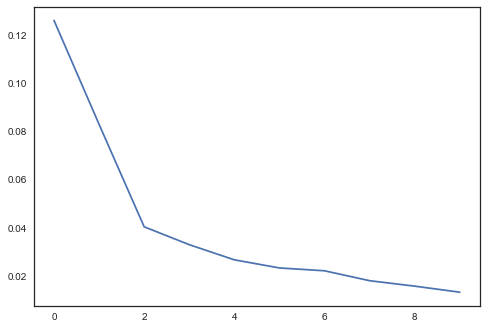

In [16]:
plt.plot(pca.explained_variance_ratio_)

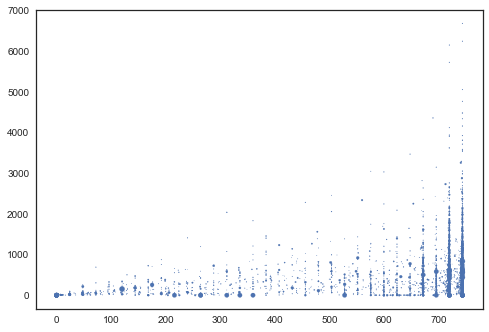

In [266]:
plt.scatter(trainset['vrema_raboty_c'], trainset['target'], s=trainset['stdbk']/30);
#plt.xlim(600);
#plt.scatter(trainset['wf'], trainset['target']);

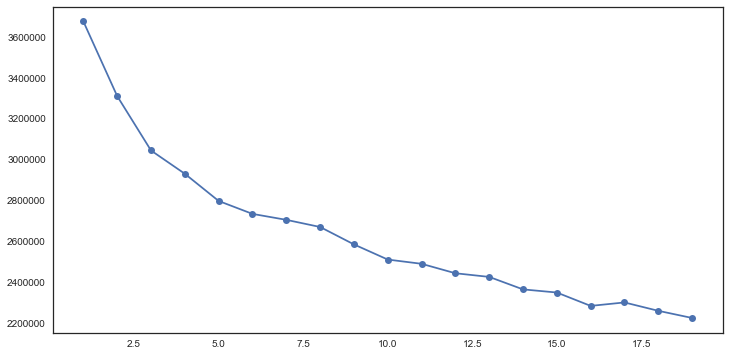

In [17]:
#choosing number of clusters
cluster_range = range( 1, 20 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( trainset_scaled )
    cluster_errors.append( clusters.inertia_ )
    
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" );

In [18]:
#create clusters 
kmeans = KMeans(n_clusters=10, random_state=17).fit(trainset_scaled)
trainset['clusters'] = kmeans.labels_
testset['clusters'] = kmeans.predict(testset_scaled)
testset2['clusters'] = kmeans.predict(testset2_scaled)

#kmeans = KMeans(n_clusters=5, random_state=17).fit(trainset_scaled)
#trainset['clusters2'] = kmeans.labels_
#testset['clusters2'] = kmeans.predict(testset_scaled)
#testset2['clusters2'] = kmeans.predict(testset2_scaled)

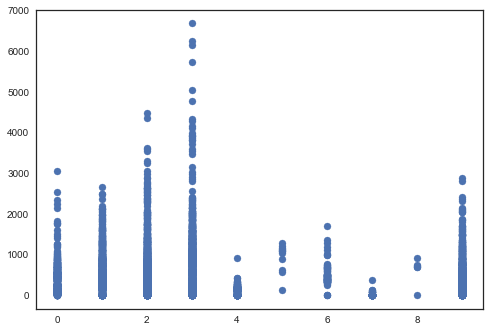

In [19]:
plt.scatter(kmeans.labels_, trainset['target'].fillna(0))

In [20]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7750 entries, 0 to 7749
Columns: 585 entries, skvajina to clusters
dtypes: datetime64[ns](1), float64(574), int32(3), int64(6), object(1)
memory usage: 34.6+ MB


In [21]:
#change datatype to float32
for c, dtype in zip(trainset.columns, trainset.dtypes):
    if dtype == np.float64:
        trainset[c] = trainset[c].astype(np.float32)
        
for c, dtype in zip(testset.columns, testset.dtypes):
    if dtype == np.float64:
        testset[c] = testset[c].astype(np.float32)
        
for c, dtype in zip(testset2.columns, testset2.dtypes):
    if dtype == np.float64:
        testset2[c] = testset2[c].astype(np.float32)

## 3. MODELING

#### Draft model

In [22]:
#custom objective function 
def fair_obj(preds, dtrain):
    """y = c * abs(x) - c**2 * np.log(abs(x)/c + 1)"""
    x = preds - dtrain.get_label()
    c = 1
    den = abs(x) + c
    grad = c*x / den
    hess = c*c / den ** 2
    return grad, hess

#custom evaluation function
def mae_feval(preds, dtrain):
    """mae = 1/n * abs(preds - true)"""
    labels = dtrain.get_label()
    
    return 'mae_eval', abs(preds - labels).mean()

In [23]:
%%time
#target: w or w/o log?

cols_xgb_del = ['date', 'skvajina'] + ['vrema_raboty_c', 'month', 'timediff', 'quarter', 'year']
cols_only_in_test = set(testset.columns) - set(trainset.columns)
cols_xgb = list(set(list(testset.drop(cols_xgb_del, axis=1).columns)) - cols_only_in_test)
#cols_xgb = deco_names+['clusters']   #alternative model
    
X_train, X_test, y_train, y_test = train_test_split(trainset[cols_xgb], 
                                                    trainset['target'], test_size=0.3, random_state=17)

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

gbm = xgb.train(params={'learning_rate':0.1}, dtrain=dtrain, num_boost_round=200, 
                maximize=False)

print("test MAE: {}".format(mean_absolute_error(y_test, gbm.predict(dtest))))
print("RSQ = {}".format(np.corrcoef(y_test.values.T, gbm.predict(dtest))[0][1] ** 2))

test MAE: 126.74481201171875
RSQ = 0.8118628217635515
Wall time: 8.72 s


In [24]:
#feature importance
import operator
importance = gbm.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
importance_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
importance_df['fscr_share'] = importance_df['fscore'] / importance_df['fscore'].sum()
importance_df.sort_values(ascending=False, by='fscore')[:20]

,feature,fscore,fscr_share
308,ica_7,1131,0.168029
307,lintrend,531,0.078889
306,fa_6,374,0.055564
305,ica_6,229,0.034022
304,grp_5,186,0.027633
303,ica_4,173,0.025702
302,tsvd_4,159,0.023622
301,tsvd_7,125,0.018571
300,grp_4,112,0.016639
299,grp_6,103,0.015302


#### Parameters' optimization

In [26]:
def score(params):
    print("Training with params:")
    print(params)
    params['max_depth'] = int(params['max_depth'])
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain, params['num_round'])
    predictions = model.predict(dvalid).reshape((X_test.shape[0], 1))
    score = mean_absolute_error(y_test, predictions) #exp
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [27]:
def optimize(trials):
    space = {
             'num_round': 100,
             'learning_rate': hp.quniform('eta', 0.01, 0.1, 0.01),
             'max_depth': hp.quniform('max_depth', 5, 14, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0.5, 1, 0.01),
             'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 1, 0.05),
             'eval_metric': 'mae',
             'objective': 'reg:linear',
             'nthread' : 4,
             'silent' : 1
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=10)
    return best

In [28]:
%%time
"""поиск набора гиперпараметров"""
trials = Trials()
best_params = optimize(trials)
best_params

Training with params:
{'colsample_bytree': 0.7000000000000001, 'eval_metric': 'mae', 'gamma': 0.51, 'learning_rate': 0.08, 'max_depth': 8.0, 'min_child_weight': 5.0, 'nthread': 4, 'num_round': 100, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.6000000000000001}
	Score 133.07713317871094


Training with params:
{'colsample_bytree': 0.8500000000000001, 'eval_metric': 'mae', 'gamma': 0.54, 'learning_rate': 0.1, 'max_depth': 14.0, 'min_child_weight': 7.0, 'nthread': 4, 'num_round': 100, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.8500000000000001}
	Score 111.01153564453125


Training with params:
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'mae', 'gamma': 1.0, 'learning_rate': 0.04, 'max_depth': 10.0, 'min_child_weight': 4.0, 'nthread': 4, 'num_round': 100, 'objective': 'reg:linear', 'silent': 1, 'subsample': 1.0}
	Score 119.6561279296875


Training with params:
{'colsample_bytree': 0.45, 'eval_metric': 'mae', 'gamma': 0.88, 'learning_rate': 0.1, 'max_depth'

In [29]:
#set models parameters
best_params['max_depth'] = int(best_params['max_depth'])
best_params['eval_metric'] = 'mae'
best_params['objective'] = 'reg:linear'
best_params['nthread'] = 4
best_params['silent'] = 1

best_params['learning_rate'] = 0.1

In [30]:
best_params

{'colsample_bytree': 0.8500000000000001,
 'eta': 0.1,
 'eval_metric': 'mae',
 'gamma': 0.54,
 'learning_rate': 0.1,
 'max_depth': 14,
 'min_child_weight': 7.0,
 'nthread': 4,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.8500000000000001}

In [31]:
%%time
#optional part
#use all train to estimate best num rounds on CV
dtrain = xgb.DMatrix(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))
xgbCvResult = xgb.cv(best_params, dtrain, num_boost_round=2000,  nfold=3, early_stopping_rounds=50, seed=17, 
                     feval=mae_feval)

Wall time: 2min 59s


best number of trees: 600


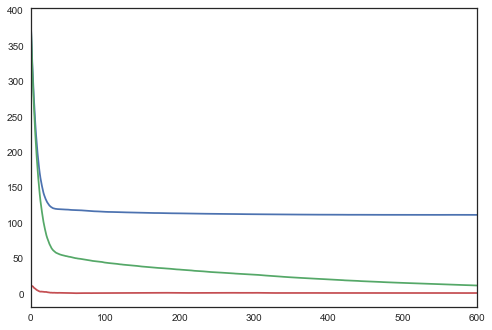

In [32]:
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult['test-mae_eval-mean']);
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult['train-mae_eval-mean']);
xgbCvResult['test-mae_eval-std'].plot();
best_num_round = np.argmin(xgbCvResult['test-mae_eval-mean'])
print('best number of trees: {}'.format(best_num_round))

In [33]:
%%time
"""cross-validation datasets"""
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=17, shuffle=True)

for i, (train_index, valid_index) in enumerate(kf.split(range(len(trainset)))):
    train_set = trainset.loc[train_index, cols_xgb + ['target']]
    valid_set = trainset.loc[valid_index, cols_xgb + ['target']]

    train_set.to_csv(r'C:\Users\drobotov\python\py_boosterspro\Gazprom Neft SmartOil Contest\task1\cv\train_' + str(i) 
                     + '.csv', index=False)
    valid_set.to_csv(r'C:\Users\drobotov\python\py_boosterspro\Gazprom Neft SmartOil Contest\task1\cv\valid_' + str(i) 
                     + '.csv',index=False)

Wall time: 24.7 s


#### CROSS VALIDATION 5-F

In [35]:
%%time

scores_tra = {}
scores_val = {}

trainset_pred = 0
testset_pred = 0
testset2_pred = 0

trainXGB = xgb.DMatrix(trainset[cols_xgb])
y = trainset['target'].values
testXGB = xgb.DMatrix(testset[cols_xgb])
test2XGB = xgb.DMatrix(testset2[cols_xgb])

for i in range(kf.n_splits):
    
    train_set = pd.read_csv(r'C:\Users\drobotov\python\py_boosterspro\Gazprom Neft SmartOil Contest\task1\cv\train_' 
                            + str(i) + '.csv', encoding="cp1251")
    val_set = pd.read_csv(r'C:\Users\drobotov\python\py_boosterspro\Gazprom Neft SmartOil Contest\task1\cv\valid_' 
                          + str(i) + '.csv', encoding="cp1251")
    
    y_train = train_set['target'].copy()
    train_set.drop('target', axis=1, inplace=True)
    y_val = val_set['target'].copy()
    val_set.drop('target', axis=1, inplace=True)
    
    train_set = xgb.DMatrix(train_set, label=y_train)
    val_set = xgb.DMatrix(val_set, label=y_val)
    
    watchlist = [(val_set, 'eval'), (train_set, 'train')] #evals
    
    gbm = xgb.train(best_params, train_set, evals=watchlist, verbose_eval=100,
                    num_boost_round=best_num_round, early_stopping_rounds=50, 
                    feval=mae_feval, obj=fair_obj, maximize=False)
    
    y_pred_tra = gbm.predict(trainXGB)
    y_pred_val = gbm.predict(val_set)
    y_pred_tes = gbm.predict(testXGB)
    y_pred_tes2 = gbm.predict(test2XGB)
    
    scores_tra['fold' + str(i)] = mae(y_pred_tra, y)
    scores_val['fold' + str(i)] = mae(y_pred_val, y_val)
    
    trainset_pred = trainset_pred + y_pred_tra
    testset_pred = testset_pred + y_pred_tes
    testset2_pred = testset2_pred + y_pred_tes2

[0]	eval-mae:393.98	train-mae:416.243	eval-mae_eval:393.98	train-mae_eval:416.243
Multiple eval metrics have been passed: 'train-mae_eval' will be used for early stopping.

Will train until train-mae_eval hasn't improved in 50 rounds.
[100]	eval-mae:245.502	train-mae:256.049	eval-mae_eval:245.502	train-mae_eval:256.049
[200]	eval-mae:228.606	train-mae:233.332	eval-mae_eval:228.605	train-mae_eval:233.332
[300]	eval-mae:221.586	train-mae:223.126	eval-mae_eval:221.586	train-mae_eval:223.126
[400]	eval-mae:216.476	train-mae:216.237	eval-mae_eval:216.476	train-mae_eval:216.237
[500]	eval-mae:212.065	train-mae:210.386	eval-mae_eval:212.065	train-mae_eval:210.386
[599]	eval-mae:208.174	train-mae:205.558	eval-mae_eval:208.174	train-mae_eval:205.558
[0]	eval-mae:405.243	train-mae:410.642	eval-mae_eval:405.243	train-mae_eval:410.642
Multiple eval metrics have been passed: 'train-mae_eval' will be used for early stopping.

Will train until train-mae_eval hasn't improved in 50 rounds.
[100]	eval-m

In [36]:
print('validation MAE score: {}, train MAE score: {}'.format(pd.Series(scores_val).mean(), pd.Series(scores_tra).mean()))

validation MAE score: 214.47910396195283, train MAE score: 206.3616516113281
